**...the next morning**

In [1]:
# Startup databrokers and elastic search
import matplotlib.pyplot as plt
%matplotlib qt5
from pprint import pprint

from rapidz.graph import _clean_text, readable_graph
from xpdan.vend.callbacks.core import Retrieve
from xpdan.vend.callbacks.zmq import Publisher
from xpdconf.conf import glbl_dict

from databroker_elasticsearch import load_elasticindex
from databroker_elasticsearch.brokersearch import BrokerSearch

from databroker import Broker
import yaml
import esconverters

dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))

FYI, the objects we have connected are  
1. databoker databases that contain the metadata about the scans
2. elastic-search indexes that have indexed the databrokers and will return just the metadata if queried
3. Broker-search objects that will return the run-start header objects when queried (this is what is needed to run the analysis)

In [2]:
an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)

1. Pavol wakes up and wonders how CJ did last night, but CJ is now sleeping soundly in his bed
1. Pavol wants to use elastic search to search the database of collected data and see how CJ did last night
1. He searches for ``tooth`` in any of the metadata fields

In [3]:
# query raw es for tooth
[d['_source']['sample_name'] for d in raw_es.qsearch('tooth')['hits']['hits']]  # search all fields

['sabertooth tiger tooth', 'shark tooth', 'dinosaur tooth']

1. He finds three datasets, so he knows that CJ had a successful night
1. He checks all the datasets ran to completion
1. He also has other ways to search for the dinosaur tooth

In [4]:
for hdr in raw_db_es('tooth'):
    print(hdr.stop)


Run Stop
exit_status     : success                                 
num_events      :
  primary         : 16                                      
run_start       : 7f56e020-501f-4f23-a3ac-99da52d1a7a3    
time            : 1555692001.4210112                      
uid             : 5ec10227-485e-4de0-955a-a6e8d831519d    

Run Stop
exit_status     : success                                 
num_events      :
  primary         : 16                                      
run_start       : cd2081bc-4442-4827-9678-5817cb57ee2a    
time            : 1555692009.5904975                      
uid             : 5cbab9f9-08db-48e9-aaa5-9a0937c00dd3    

Run Stop
exit_status     : success                                 
num_events      :
  primary         : 16                                      
run_start       : 4e6668e1-9acb-489e-a6a0-25a04899bde2    
time            : 1555696689.3094292                      
uid             : 80d45ff9-93c1-4f03-b850-ab264b88406d    


In [5]:
raw_es.qsearch('dinosaur')  # search all fields

{'took': 9,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 1,
  'max_score': 0.6931472,
  'hits': [{'_index': 'demo-raw',
    '_type': 'run_start',
    '_id': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
    '_score': 0.6931472,
    '_source': {'detectors': ['img'],
     'num_points': 16,
     'plan_name': 'list_scan',
     'scan_id': 1,
     'time': 1555696681.0151916,
     'uid': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
     'date': '2019-04-19T13:58:01.015',
     'sample_name': 'dinosaur tooth'}}]}}

In [6]:
raw_es.qsearch('sample_name:dinosaur')  # search specific field

{'took': 4,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 1,
  'max_score': 0.6931472,
  'hits': [{'_index': 'demo-raw',
    '_type': 'run_start',
    '_id': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
    '_score': 0.6931472,
    '_source': {'detectors': ['img'],
     'num_points': 16,
     'plan_name': 'list_scan',
     'scan_id': 1,
     'time': 1555696681.0151916,
     'uid': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
     'date': '2019-04-19T13:58:01.015',
     'sample_name': 'dinosaur tooth'}}]}}

In [ ]:
raw_es.qsearch('dino*')  # glob-like search

In [7]:
raw_es.qsearch('dinosaurus~2')  # fuzzy search max edit distance of 2

{'took': 85,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 1,
  'max_score': 0.5198604,
  'hits': [{'_index': 'demo-raw',
    '_type': 'run_start',
    '_id': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
    '_score': 0.5198604,
    '_source': {'detectors': ['img'],
     'num_points': 16,
     'plan_name': 'list_scan',
     'scan_id': 1,
     'time': 1555696681.0151916,
     'uid': '4e6668e1-9acb-489e-a6a0-25a04899bde2',
     'date': '2019-04-19T13:58:01.015',
     'sample_name': 'dinosaur tooth'}}]}}

In [8]:
raw_hdr = next(iter(raw_db_es('dinosaurus~2')))
uid = raw_hdr.start['uid']

1. Pavol also wants to know if CJ was able to do any analysis on the data during the night
1. Pavol searches the databroker that contains analyzed data

In [9]:
# queries with an_es
an_es.qsearch('img_sinogram', size=0)

{'took': 16,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 3, 'max_score': 0.0, 'hits': []}}

In [10]:
an_es.qsearch('img_sinogram')

{'took': 19,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 0.2876821,
  'hits': [{'_index': 'demo-an',
    '_type': 'run_start',
    '_id': '41e9788f-a504-4f9a-b446-a4d949568697',
    '_score': 0.2876821,
    '_source': {'uid': '41e9788f-a504-4f9a-b446-a4d949568697',
     'puid': ['7f56e020-501f-4f23-a3ac-99da52d1a7a3'],
     'analysis_stage': 'img_sinogram',
     'usednodes': [{'ndtype': 'shed.translation.ToEventStream',
       'ndkwargs': {'analysis_stage': 'img_sinogram'}},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'xpdtools.pipelines.tomo.conditional_squeeze'},
      {'ndtype': 'rapidz.core.starmap',
       'ndfunc': 'xpdtools.pipelines.tomo.sort_sinogram'},
      {'ndtype': 'rapidz.core.accumulate',
       'ndfunc': 'xpdtools.pipelines.tomo.append_data'},
      {'ndtype': 'rapidz.core.zip'},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'tomopy.prep.normalize.minus_log'},
      {'nd

In [11]:
an_es.qsearch(f'puid:{uid[:6]}*')  # word in puid

{'took': 15,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 2,
  'max_score': 1.0,
  'hits': [{'_index': 'demo-an',
    '_type': 'run_start',
    '_id': '9c1c6aab-5681-46f4-9069-4eebad27a554',
    '_score': 1.0,
    '_source': {'uid': '9c1c6aab-5681-46f4-9069-4eebad27a554',
     'puid': ['4e6668e1-9acb-489e-a6a0-25a04899bde2'],
     'analysis_stage': 'img_sinogram',
     'usednodes': [{'ndtype': 'shed.translation.ToEventStream',
       'ndkwargs': {'analysis_stage': 'img_sinogram'}},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'xpdtools.pipelines.tomo.conditional_squeeze'},
      {'ndtype': 'rapidz.core.starmap',
       'ndfunc': 'xpdtools.pipelines.tomo.sort_sinogram'},
      {'ndtype': 'rapidz.core.accumulate',
       'ndfunc': 'xpdtools.pipelines.tomo.append_data'},
      {'ndtype': 'rapidz.core.zip'},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'tomopy.prep.normalize.minus_log'},
      {'ndtype': 'rapi

In [ ]:
an_es.qsearch('analysis_stage:img_sinogram')

In [ ]:
an_es.qsearch('usednodes.ndfunc:*sort_sinogram')

In [12]:
an_es.qsearch('gridrec')

{'took': 14,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 0.2876821,
  'hits': [{'_index': 'demo-an',
    '_type': 'run_start',
    '_id': '5ed03d9a-a080-4fb4-99a9-ac8dcbfb990d',
    '_score': 0.2876821,
    '_source': {'uid': '5ed03d9a-a080-4fb4-99a9-ac8dcbfb990d',
     'puid': ['7f56e020-501f-4f23-a3ac-99da52d1a7a3'],
     'analysis_stage': 'img_tomo',
     'usednodes': [{'ndtype': 'shed.translation.ToEventStream',
       'ndkwargs': {'analysis_stage': 'img_tomo'}},
      {'ndtype': 'rapidz.core.starmap',
       'ndfunc': 'xpdtools.pipelines.tomo.recon_wrapper',
       'ndkwargs': {'algorithm': 'gridrec'}},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'xpdtools.pipelines.tomo.flatten'},
      {'ndtype': 'rapidz.core.combine_latest', 'ndkwargs': {'emit_on': 0}},
      {'ndtype': 'rapidz.core.accumulate',
       'ndfunc': 'xpdtools.pipelines.tomo.append_data'},
      {'ndtype': 'rapidz.core.zip'}

In [ ]:
an_es.qsearch('usednodes.ndkwargs.algorithm:gridrec')

1. Pavol wants to know if there was a tomographic reconstruction already done?

In [13]:
# query an_es/databroker for tomo recon
hdrs = an_db_es('analysis_stage:*tomo*')
tomo_analysis_hdr = next(iter(hdrs))

1. Now Pavol wants to replay the same analysis from the database as a sanity check to see if he gets the same answer.
1. He wants to see exactly what analysis CJ did during the night, so he plots the analysis graph that he found in the database from the analysis done last night.

/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/dxchange/reader.py:97: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(modname + ' module not found')


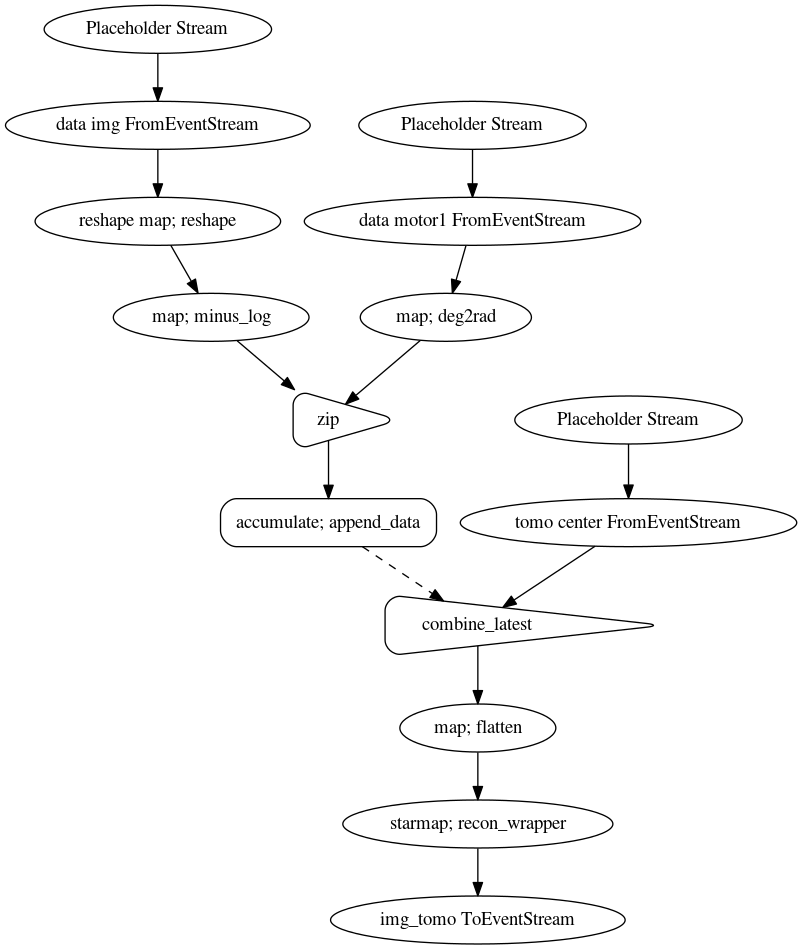

In [14]:
# load and show the graph
from shed.replay import replay

# load the replay
graph, parents, data, vs = replay(raw_db, tomo_analysis_hdr)

# make the graph more accessible to humans by renaming things
# these names *should* match the names in the graph plot
for k, v in graph.nodes.items():
    v.update(label=_clean_text(str(v['stream'])).strip())
graph = readable_graph(graph)

# plot the graph
graph.nodes['data img FromEventStream']['stream'].visualize()

1. Each unique analysis has its own unique id.
2. Each unique graph has its own unique id.

In [15]:
hdrs = list(an_db_es('usednodes.ndkwargs.algorithm:gridrec'))
for hdr in hdrs:
    print('analysis id:', hdr.start['uid'])
for hdr in hdrs:
    print('graph id:', hdr.start['graph_hash'])

analysis id: 5ed03d9a-a080-4fb4-99a9-ac8dcbfb990d
analysis id: 71b5efd4-5914-4ab6-b47e-d5b6a22bdfaa
analysis id: 1ba03e31-64c2-4406-99fb-8d1488e64f79
graph id: 9a74309687ed374cb5426b45ed7940cda720356930720c802832e8079b857ad4
graph id: 9a74309687ed374cb5426b45ed7940cda720356930720c802832e8079b857ad4
graph id: 9a74309687ed374cb5426b45ed7940cda720356930720c802832e8079b857ad4


In [16]:
# setup a publisher to send over to data viz and capture
p = Publisher(glbl_dict['inbound_proxy_address'], prefix=b'tomo')
z = graph.nodes['img_tomo ToEventStream']['stream'].LastCache().DBFriendly()
z.starsink(p)

Output()

1. As a sanity check, Pavol replays the analysis from last night with no changes

In [17]:
# replay analysis with no changes
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

1. Pavol now changes the recostruction algorithm to ``algebraic``.  It is the node called ``recon_wrapper`` and he wants the keyword argument ``algorithm`` to be set to ``'art'`` which selects the reconstruction algorithm we want to use.
1. He then reruns the analysis through the new pipeline, which has just changed by one node.

In [18]:
# change to Algebraic Reconstruction technique
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)
graph.nodes['starmap; recon_wrapper']['stream'].kwargs['algorithm'] = 'art'
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)

# replay with changes
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

{'algorithm': 'gridrec'}
{'algorithm': 'art'}


1. Just because he can, Pavol compares the ID of the previous graph and the new one.  They are different because the graphs are different.

In [19]:
# These hashes are different because the algorithms are different
dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))
from databroker_elasticsearch.converters import register_converter

an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)

print(an_db[-1].start['graph_hash'])
print(an_db[-2].start['graph_hash'])

e6f0106d528e31de208b66ecda76c2a3a752f5fbfde754dea5237de40c005109
4da4d685acd7848496ecd757043ac00ff7e136be2eaefb580729230758857eaa


1. Pavol searches elastic search for the art reconstruction data
1. Not surprisingly, Pavol wants to compare the previous analysis to the new one.
1. To do this, he retrieves the last event from each stream and plots them

In [20]:
# an_es for new data (via new recon algo)
dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))
from databroker_elasticsearch.converters import register_converter

an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)
vqan = lambda q: pprint((q, an_es.qsearch(q)))

an_es.qsearch('art')

{'took': 9,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 1,
  'max_score': 0.6931472,
  'hits': [{'_index': 'demo-an',
    '_type': 'run_start',
    '_id': 'da7417ef-7eca-4f1c-bc8e-8c0794643bb2',
    '_score': 0.6931472,
    '_source': {'uid': 'da7417ef-7eca-4f1c-bc8e-8c0794643bb2',
     'puid': ['7f56e020-501f-4f23-a3ac-99da52d1a7a3'],
     'analysis_stage': 'img_tomo',
     'usednodes': [{'ndtype': 'shed.translation.ToEventStream',
       'ndfunc': 'img_tomo',
       'ndkwargs': {'analysis_stage': 'img_tomo'}},
      {'ndtype': 'rapidz.core.starmap',
       'ndfunc': 'xpdtools.pipelines.tomo.recon_wrapper',
       'ndkwargs': {'algorithm': 'art'}},
      {'ndtype': 'rapidz.core.map',
       'ndfunc': 'xpdtools.pipelines.tomo.flatten'},
      {'ndtype': 'rapidz.core.combine_latest', 'ndkwargs': {'emit_on': 0}},
      {'ndtype': 'rapidz.core.accumulate',
       'ndfunc': 'xpdtools.pipelines.tomo.append_data'},
      {'ndt

/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


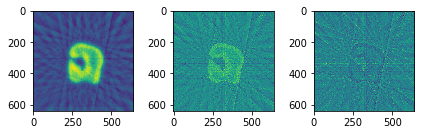

In [21]:
hdr1 = next(iter(an_db_es('usednodes.ndkwargs.algorithm:art')))
hdr2 = next(iter(an_db_es('usednodes.ndkwargs.algorithm:gridrec')))

art = next(hdr1.data('img_tomo', stream_name='final_primary'))
grid = next(hdr2.data('img_tomo', stream_name='final_primary'))

# Compare results
fig, axs = plt.subplots(1, 3, tight_layout=True)
for img, ax in zip([art, grid], axs):
    ax.imshow(img)
axs[-1].imshow(art - grid)
plt.savefig('reconstructions.png', transparent=True, bbox_inches='tight')